### ACROBOT ###


In [1]:
# Libraries will not be installed if running on ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed on your local system
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_acrobot.txt;

In [2]:
import os
import numpy as np
import itertools
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange
import gym
import wrappers

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable
from torchsummary import summary
from importlib import reload

# from networks import NNetwork, NeuralNetworkPolicy
from agents import Q_Agent, Q_DQN_Agent, SARSA_Agent, SARSA_DQN_Agent
from agents_nnp import AAC_Agent, MC_PolGrad_Agent

%load_ext autoreload
%autoreload 2

Acrobot is a 2-link pendulum with only the second joint actuated.
Initially, both links point downwards. The goal is to swing the
end-effector at a height at least the length of one link above the base.
Both links can swing freely and can pass by each other, i.e., they don't
collide when they have the same angle.

**STATE:**
The state consists of the sin() and cos() of the two rotational joint
angles and the joint angular velocities :
[cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2].
For the first link, an angle of 0 corresponds to the link pointing downwards.
The angle of the second link is relative to the angle of the first link.
An angle of 0 corresponds to having the same angle between the two links.
A state of [1, 0, 1, 0, ..., ...] means that both links point downwards.

**ACTIONS:**
The action is either applying +1, 0 or -1 torque on the joint between
the two pendulum links.

In [3]:
# Define the environment
env = gym.make('Acrobot-v1')

# Set a seed for reproducing results
# random_seed = 1234
# np.random.seed(random_seed)
# torch.manual_seed(random_seed)
# env.seed(random_seed);

In [4]:
# What is the type and size of the action space
print("Action space: {}".format(env.action_space))  # 3 discrete actions, 

# What does an action look like
sample_action = env.action_space.sample()  # Action can be one of these: 0, 1, 2
print("Sample action: {}".format(sample_action))  # Execute multiple times to see different actions
print("Type of action: {}".format(type(sample_action)))

# What is the type and size of the observation (state) space
print("Observationtate space: {}".format(env.observation_space))  # continuous states

# Which state does the agent start in?
initial_state = env.reset()
print("Initial state: {}".format(initial_state))  

# What is an observation
sample_observation = env.observation_space.sample()
print("Sample observation: {}".format(sample_observation))
print("Type of observation: {}".format(type(sample_observation)))

Action space: Discrete(3)
Sample action: 1
Type of action: <class 'int'>
Observationtate space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
Initial state: [ 0.99860828  0.05274001  0.99996126 -0.00880199  0.00622043 -0.05980209]
Sample observation: [ 0.78716874 -0.5753727  -0.3741619   0.16238068  4.0181317   1.300775  ]
Type of observation: <class 'numpy.ndarray'>


In [5]:
###TRAINING####
training_results = list() # A list for storing the hyperparameters and the corresponding results
max_episodes = 1000

In [6]:
### Train AAC-Agent (neural network policy - agent) ###
hyperparam_dict = {'name': 'AAC-Agent', 'learning_rate':0.01, 'gamma':0.99}

aac_agent = AAC_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.001,
                      gamma=0.99, hidden_dim=100, dropout=0.6, log_interval=5)
ep_rewards, running_rewards = aac_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 5	Last reward: -500.00	Average reward: -499.68
Episode 10	Last reward: -500.00	Average reward: -499.76
Episode 15	Last reward: -500.00	Average reward: -498.29
Episode 20	Last reward: -500.00	Average reward: -495.83
Episode 25	Last reward: -500.00	Average reward: -496.49
Episode 30	Last reward: -500.00	Average reward: -491.25
Episode 35	Last reward: -500.00	Average reward: -493.23
Episode 40	Last reward: -500.00	Average reward: -494.76
Episode 45	Last reward: -500.00	Average reward: -495.95
Episode 50	Last reward: -500.00	Average reward: -496.86
Episode 55	Last reward: -500.00	Average reward: -497.57
Episode 60	Last reward: -500.00	Average reward: -498.12
Episode 65	Last reward: -500.00	Average reward: -498.55
Episode 70	Last reward: -500.00	Average reward: -498.88
Episode 75	Last reward: -500.00	Average reward: -499.13
Episode 80	Last reward: -500.00	Average reward: -499.33
Episode 85	Last reward: -500.00	Average reward: -499.48
Episode 90	Last reward: -500.00	Avera

In [7]:
### Train Monte Carlo policy gradient Agent (REINFORCE - Agent) ###
hyperparam_dict = {'name': 'MC_PolGrad-Agent', 'learning_rate':0.001, 'gamma':0.99}
mc_polGrad_agent = MC_PolGrad_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.001,
                      gamma=0.99, hidden_dim=100, dropout=0.6, log_interval=5)
ep_rewards, running_rewards = mc_polGrad_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 5	Last reward: -500.00	Average reward: -500.00
Episode 10	Last reward: -500.00	Average reward: -500.00
Episode 15	Last reward: -500.00	Average reward: -500.00
Episode 20	Last reward: -500.00	Average reward: -500.00
Episode 25	Last reward: -473.00	Average reward: -498.65
Episode 30	Last reward: -500.00	Average reward: -498.96
Episode 35	Last reward: -353.00	Average reward: -491.84
Episode 40	Last reward: -500.00	Average reward: -493.69
Episode 45	Last reward: -500.00	Average reward: -493.12
Episode 50	Last reward: -500.00	Average reward: -488.36
Episode 55	Last reward: -500.00	Average reward: -490.99
Episode 60	Last reward: -500.00	Average reward: -493.03
Episode 65	Last reward: -500.00	Average reward: -494.61
Episode 70	Last reward: -500.00	Average reward: -495.83
Episode 75	Last reward: -500.00	Average reward: -496.77
Episode 80	Last reward: -500.00	Average reward: -497.50
Episode 85	Last reward: -500.00	Average reward: -498.07
Episode 90	Last reward: -500.00	Avera

In [8]:
### Train SARSA-Agent (semi-gradient) ###
hyperparam_dict = {'name': 'SARSA-Agent', 'learning_rate':0.0002, 'gamma':0.99, 'epsilon':0.1}
sarsa_agent = SARSA_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.0001,
                          gamma=0.99, epsilon=0.2, n_hidden_neurons=16, log_interval=5)
ep_rewards, running_rewards = sarsa_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 5	Last reward: -500.00	Average reward: -500.00
Episode 10	Last reward: -481.00	Average reward: -484.43
Episode 15	Last reward: -500.00	Average reward: -480.75
Episode 20	Last reward: -500.00	Average reward: -482.49
Episode 25	Last reward: -500.00	Average reward: -485.72
Episode 30	Last reward: -500.00	Average reward: -488.95
Episode 35	Last reward: -500.00	Average reward: -491.45
Episode 40	Last reward: -500.00	Average reward: -493.38
Episode 45	Last reward: -500.00	Average reward: -494.88
Episode 50	Last reward: -500.00	Average reward: -496.04
Episode 55	Last reward: -500.00	Average reward: -496.93
Episode 60	Last reward: -500.00	Average reward: -497.63
Episode 65	Last reward: -500.00	Average reward: -498.16
Episode 70	Last reward: -500.00	Average reward: -498.58
Episode 75	Last reward: -500.00	Average reward: -498.90
Episode 80	Last reward: -500.00	Average reward: -499.15
Episode 85	Last reward: -500.00	Average reward: -499.34
Episode 90	Last reward: -500.00	Avera

In [9]:
### Train Q-Agent (semi-gradient) ###
hyperparam_dict = {'name': 'Q-Agent', 'learning_rate':0.0001, 'gamma':0.99, 'epsilon':0.1}
q_agent = Q_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.0001,
                  gamma=0.99, epsilon=0.1, n_hidden_neurons=200, log_interval=100)
ep_rewards, running_rewards = q_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 100	Last reward: -500.00	Average reward: -499.69
Episode 200	Last reward: -500.00	Average reward: -473.18
Episode 300	Last reward: -232.00	Average reward: -250.84
Episode 400	Last reward: -214.00	Average reward: -286.22
Episode 500	Last reward: -394.00	Average reward: -368.21
Episode 600	Last reward: -500.00	Average reward: -460.11
Episode 700	Last reward: -500.00	Average reward: -498.84
Episode 800	Last reward: -500.00	Average reward: -499.99
Episode 900	Last reward: -500.00	Average reward: -499.48
Episode 1000	Last reward: -500.00	Average reward: -499.39
Max episodes exceeded, quitting.


In [10]:
### Train Q_DQN-Agent (semi-gradient) ###
# neurons=16 and epsilon=0.2
hyperparam_dict = {'name': 'Q-DQN-Agent', 'learning_rate':0.0001, 'gamma':0.99, 'epsilon':0.1}
q_dqn_agent = Q_DQN_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.0001,
                  gamma=0.99, epsilon=0.2, n_hidden_neurons=16, log_interval=5)
ep_rewards, running_rewards = q_dqn_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 5	Last reward: -157.00	Average reward: -427.18
Episode 10	Last reward: -500.00	Average reward: -424.34
Episode 15	Last reward: -217.00	Average reward: -383.80
Episode 20	Last reward: -117.00	Average reward: -331.93
Episode 25	Last reward: -124.00	Average reward: -287.08
Episode 30	Last reward: -125.00	Average reward: -252.32
Episode 35	Last reward: -174.00	Average reward: -236.41
Episode 40	Last reward: -218.00	Average reward: -223.78
Episode 45	Last reward: -174.00	Average reward: -215.76
Episode 50	Last reward: -147.00	Average reward: -204.90
Episode 55	Last reward: -203.00	Average reward: -208.26
Episode 60	Last reward: -178.00	Average reward: -205.11
Episode 65	Last reward: -319.00	Average reward: -212.64
Episode 70	Last reward: -173.00	Average reward: -209.32
Episode 75	Last reward: -169.00	Average reward: -209.26
Episode 80	Last reward: -238.00	Average reward: -210.27
Episode 85	Last reward: -214.00	Average reward: -210.61
Episode 90	Last reward: -153.00	Avera

In [11]:
### Train SARSA_DQN-Agent (semi-gradient) ###
# neurons=16 and epsilon=0.2
hyperparam_dict = {'name': 'SARSA-DQN-Agent', 'learning_rate':0.0001, 'gamma':0.99, 'epsilon':0.1}
sarsa_dqn_agent = SARSA_DQN_Agent(env, num_episodes=max_episodes, num_steps=500, learning_rate=0.0001,
                  gamma=0.99, epsilon=0.2, n_hidden_neurons=16, log_interval=5)
ep_rewards, running_rewards = sarsa_dqn_agent.train()
training_results.append((hyperparam_dict, ep_rewards, running_rewards))

Training...
Episode 5	Last reward: -353.00	Average reward: -439.61
Episode 10	Last reward: -296.00	Average reward: -400.08
Episode 15	Last reward: -451.00	Average reward: -402.57
Episode 20	Last reward: -437.00	Average reward: -421.32
Episode 25	Last reward: -211.00	Average reward: -417.04
Episode 30	Last reward: -223.00	Average reward: -392.05
Episode 35	Last reward: -277.00	Average reward: -392.63
Episode 40	Last reward: -421.00	Average reward: -375.35
Episode 45	Last reward: -300.00	Average reward: -371.80
Episode 50	Last reward: -319.00	Average reward: -377.12
Episode 55	Last reward: -242.00	Average reward: -366.44
Episode 60	Last reward: -260.00	Average reward: -375.45
Episode 65	Last reward: -500.00	Average reward: -400.45
Episode 70	Last reward: -500.00	Average reward: -422.97
Episode 75	Last reward: -500.00	Average reward: -440.40
Episode 80	Last reward: -500.00	Average reward: -453.88
Episode 85	Last reward: -500.00	Average reward: -464.31
Episode 90	Last reward: -500.00	Avera

KeyboardInterrupt: 

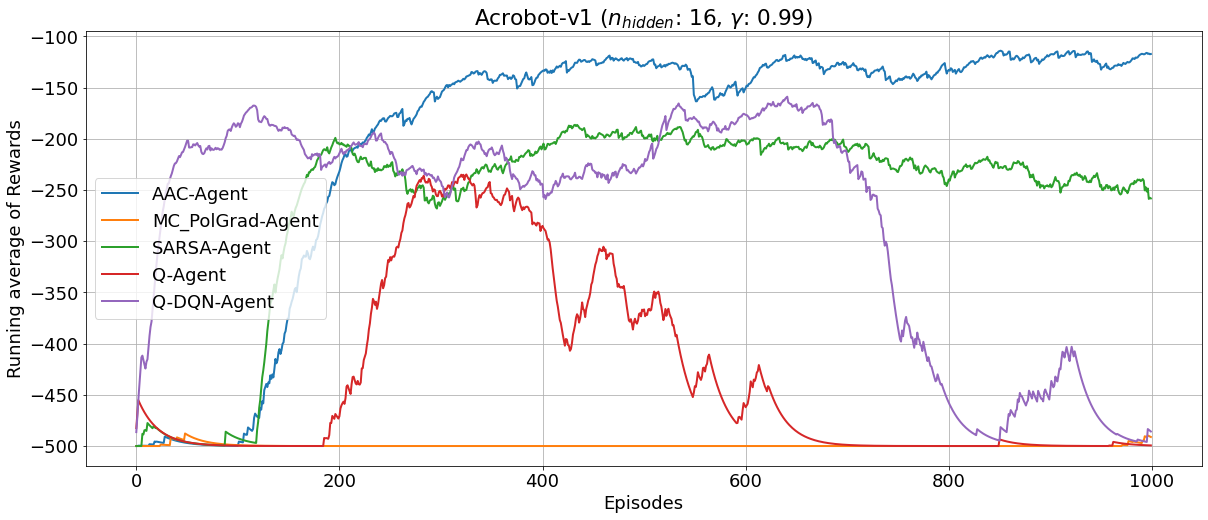

In [19]:
plt.rcParams.update({'font.size': 18})

# Plot the results
fig = plt.figure(1, figsize=(20,8))

for result in training_results:
    hp = result[0]
    ep_rewards = result[1]
    running_rewards = result[2]
    # plt.plot(range(len(ep_rewards)), ep_rewards, lw=2, color="red", label=hp['name'])
    plt.plot(range(len(running_rewards)), running_rewards, lw=2, label=hp['name'])
    
    # title_str = hp['name'] + '($\gamma$:' + str(hp['gamma']) + ',lr:' + str(hp['learning_rate']) + ')'
    title_str = "Acrobot-v1 ($n_{hidden}$: 16, $\gamma$: 0.99)"
    plt.title(title_str)

plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Running average of Rewards')
plt.legend() # ncol=1
plt.show()

In [ ]:
ep_rewards = sarsa_agent.evaluation(n_episodes=10)

In [ ]:
ep_rewards = q_dqn_agent.evaluation(n_episodes=10)

In [32]:
####VIDEO#####
env_to_wrap = gym.make('Acrobot-v1')
env = gym.wrappers.Monitor(env_to_wrap, 'videos/AAC', force = True)
ep_rewards = aac_agent.polGrad_evaluation(n_episodes=10, vid_env=env)
env.close()
env_to_wrap.close()

Evaluation...
Episode 1	Reward: -104.00
Episode 2	Reward: -121.00
Episode 3	Reward: -90.00
Episode 4	Reward: -107.00
Episode 5	Reward: -102.00
Episode 6	Reward: -140.00
Episode 7	Reward: -95.00
Episode 8	Reward: -146.00
Episode 9	Reward: -105.00
Episode 10	Reward: -75.00


In [34]:
env_to_wrap = gym.make('Acrobot-v1')
env = gym.wrappers.Monitor(env_to_wrap, 'videos/SARSA', force = True)
ep_rewards = sarsa_agent.evaluation(n_episodes=3, vid_env=env)
env.close()
env_to_wrap.close()

Evaluation...
Episode 1	Reward: -210.00
Episode 2	Reward: -168.00
Episode 3	Reward: -248.00
